Make our custom modules available to numpy


In [39]:
import sys
sys.path.append('.')

Load some generic libraries


In [40]:
import pandas as pd
import numpy as np
import warnings
import random
import time
# pandas setting warnings can be ignored, as it is intendend often
warnings.simplefilter("ignore")

In [41]:
import matplotlib.pyplot as plt 

Load the custom modules


In [42]:
from agents import Buyer, Seller
from environments import MarketEnvironment
from automatic_agents import AutomaticBuyer, AutomaticSeller
from rl_agents import RLSeller
from static_agent import StaticSeller

Let's meet our agents
The cost or budget for sellers and buyers, is also referred to as reservation price in general.

Sellers first:

In [43]:
cost = 100

ali = RLSeller('Seller Ali', cost)
# static = StaticSeller('Seller Static', cost)
mehmet = AutomaticSeller('Seller Mehmet', cost)
ahmet = AutomaticSeller('Seller Ahmet', cost)
ayse = AutomaticSeller('Seller Ayse', cost)
fatma = AutomaticSeller('Seller Fatma', cost)

sellers = [ali,mehmet,ahmet,ayse,fatma]

# in order to update them in the for loop
other_sellers = [mehmet,ahmet,ayse,fatma]

In [44]:
budget = 200

can = AutomaticBuyer('Buyer Can', budget)
cem = AutomaticBuyer('Buyer Cem', budget)
bora = AutomaticBuyer('Buyer Bora', budget)
ozan = AutomaticBuyer('Buyer Ozan', budget)
utku = AutomaticBuyer('Buyer Utku', budget)

# You can disclude "can" and use q_table_competitive or include him and use q_table if you want to test the competitive environment.
buyers = [cem,bora,ozan,utku] 

Now lets prepare our environment
First let's load an information setting
then let's load a matcher


In [45]:
from info_settings import BlackBoxSetting
from matchers import RandomMatcher

Now let's create the environment, and be careful because now I am using a reward scheme based on reservation price. Is this scheme better for my research goal? If yes why?

In [46]:
market_env = MarketEnvironment(sellers=sellers, buyers=buyers, max_steps=10,  
                               matcher=RandomMatcher(reward_on_reference=True), setting=BlackBoxSetting)



Now let's run a single step, deciding offers for all agents:
first we clean the environment, just in case
everything should be zeroes.

In [47]:
init_observation = market_env.reset()

In [56]:
# Hyperparameters
alpha = 0.35
gamma = 0.9
epsilon = 0 # we are not using it right now because we have a bool for training or test mode for training epsilon is 1 for test 0
boolean_training = False # This should be True for training and false for testing

In [52]:
# q_table = np.zeros((21,3)) # This should only be run for a new training

In [57]:
q_table = np.loadtxt('q_table_competitive.txt') # This can be used for later testing.

In [58]:
# measure time
start_time = time.time()

# in order to get the total rewards at the end
list_of_rewards = {}
normalized_list_of_rewards = {}

# initialize them with 0 rewards
for buyer in buyers:
        list_of_rewards[buyer.agent_id] = 0

for seller in sellers:
        list_of_rewards[seller.agent_id] = 0

# number of games
# For Training optimal is 1000 and for testing between 30-50 is good number.
for i in range (0,50):
    
    init_observation = market_env.reset()
    

    # number of rounds    
    while market_env.time < 10 and market_env.done:
        
        if random.uniform(0, 1) < epsilon:
            boolean = True
        else:
            boolean = False

        # dictionary of the actions in current state
        actions = {}        
        
        # in order to update the rl agent save the previous offer and action in order to update the q table
        last_offer, action = ali.update_offer(actions, 
                                              market_env.setting.get_state(ali.agent_id ,market_env.agents,market_env.deal_history,market_env.offers), 
                                              q_table, boolean_training)
        # get all the other agents' actions
        for agent in buyers:
            agent.update_offer(actions, market_env.setting.get_state(agent.agent_id, market_env.agents, market_env.deal_history, market_env.offers))
        for agent in other_sellers:
            agent.update_offer(actions, market_env.setting.get_state(agent.agent_id, market_env.agents, market_env.deal_history, market_env.offers))
       
        # play one step
        observations, rewards, done, _ = market_env.step(actions)
        
        # get cumulitive rewards
        for buyer in buyers:
            list_of_rewards[buyer.agent_id] = list_of_rewards.get(buyer.agent_id,0) + rewards.get(buyer.agent_id,0)
            
        for seller in sellers:
            list_of_rewards[seller.agent_id] = list_of_rewards.get(seller.agent_id,0) + rewards.get(seller.agent_id,0)
        
        # find the next action of the rl agent
        next_state = market_env.setting.get_state(ali.agent_id ,market_env.agents,market_env.deal_history,market_env.offers)
        
        # get the old_value to calculate the new one
        old_value = q_table[int((last_offer-100)/5), int(action)]
        next_max = np.max(q_table[int((next_state-100)/5)])
        
        # if training mode update q table else don't
        if boolean_training: 
            new_value = (1 - alpha) * old_value + alpha * (rewards.get(ali.agent_id,0) + gamma * next_max)
            q_table[int((last_offer-100)/5), int(action)] = new_value

if not boolean_training:
    # get the normalized rewards
    for buyer in buyers:
        normalized_list_of_rewards[buyer.agent_id] = list_of_rewards.get(buyer.agent_id,0)/list_of_rewards.get(ali.agent_id,0)

    for seller in sellers:
        normalized_list_of_rewards[seller.agent_id] = list_of_rewards.get(seller.agent_id,0)/list_of_rewards.get(ali.agent_id,0)

    # display last game
    display(pd.DataFrame(market_env.deal_history))

    # display the rewards
    display(list_of_rewards)
    display(normalized_list_of_rewards)
    average_reward_rest = 0
    for seller in other_sellers:
        average_reward_rest += normalized_list_of_rewards.get(seller.agent_id,0)
    average_reward_rest = average_reward_rest / np.size(other_sellers)
    print("This is the average performance increase: " + str(int((normalized_list_of_rewards.get(ali.agent_id,0)/average_reward_rest - 1) * 100)) + '%')

# print the elapsed time
elapsed_time = time.time() - start_time
print("Time passed: " + str(int(elapsed_time)) + " seconds.")
        
        

,Seller,Buyer,time,deal_price
0,Seller Ayse,Buyer Bora,3,145.666907
1,Seller Ali,Buyer Utku,4,148.660516
2,Seller Ahmet,Buyer Ozan,4,148.439210
3,Seller Fatma,Buyer Cem,5,144.454865


{'Buyer Cem': 2367.6055828866783,
 'Buyer Bora': 2387.7816822064933,
 'Buyer Ozan': 2418.2794147280306,
 'Buyer Utku': 2417.986955972794,
 'Seller Ali': 1840.0,
 'Seller Mehmet': 1749.0201336373011,
 'Seller Ahmet': 1262.479939322077,
 'Seller Ayse': 1433.426873564425,
 'Seller Fatma': 1583.612799939127}

{'Buyer Cem': 1.2867421646123252,
 'Buyer Bora': 1.29770743598179,
 'Buyer Ozan': 1.31428229061306,
 'Buyer Utku': 1.314123345637388,
 'Seller Ali': 1.0,
 'Seller Mehmet': 0.950554420455055,
 'Seller Ahmet': 0.6861304018054766,
 'Seller Ayse': 0.7790363443284919,
 'Seller Fatma': 0.8606591304016994}

This is the average performance increase: 22%
Time passed: 11 seconds.


In [54]:
# np.savetxt('q_table_competitive.txt', q_table)
display(q_table)

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , 46.97829175],
       [ 1.09876295, 47.26992129, 46.87205039],
       [11.06160275, 43.28256868, 39.33263569],
       [25.16046561, 28.61909327, 24.68801095],
       [ 5.74610303, 10.13574201,  8.65773687],
       [47.61525339,  9.11003483, 45.32327907],
       [42.64770542, 38.62368717, 38.35345579],
       [40.88185866, 42.70316811, 49.9352278 ],
       [29.86541739, 29.8755798 , 29.31815091],
       [21.94398498, 36.66202699, 36.56939144],
       [52.97218513, 38.77352339, 48.07454949],
       [48.11095281, 49.09338785, 46.83074874],
       [62.91422702, 46.22731666, 58.85003244],
       [60.80688669, 58.53177722, 54.55742888],
       [36.12708713, 54.23603226, 51.31191582],
       [55.36098288, 55.16719966, 56.91751231],
       [46.64134132, 56.58186913, 52.78417456],
       [64.38849027, 51.16607877, 56.73318202],
       [55.42403047, 57.63926352, 51.72644957],
       [50.79115773, 51.99280151, 47.011

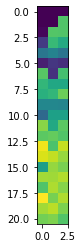

In [55]:
plt.imshow(q_table)

In [59]:
pd.DataFrame(market_env.deal_history)

,Seller,Buyer,time,deal_price
0,Seller Ayse,Buyer Bora,3,145.666907
1,Seller Ali,Buyer Utku,4,148.660516
2,Seller Ahmet,Buyer Ozan,4,148.439210
3,Seller Fatma,Buyer Cem,5,144.454865


and the history of offers

In [60]:
market_env.offers

,id,res_price,role,offer,time
0,Seller Ali,100,Seller,140.000000,4
1,Seller Mehmet,100,Seller,122.632084,9
2,Seller Ahmet,100,Seller,144.469557,4
3,Seller Ayse,100,Seller,140.036993,3
4,Seller Fatma,100,Seller,133.555044,5
5,Buyer Cem,200,Buyer,150.063340,5
6,Buyer Bora,200,Buyer,146.363150,3
7,Buyer Ozan,200,Buyer,150.339749,4
8,Buyer Utku,200,Buyer,152.098213,4
